In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import itertools
from collections import Counter

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from cycler import cycler

In [85]:
from scipy import stats
from scipy.stats import norm, gamma, linregress, skew
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import pymc3 as pm

In [6]:
def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [7]:
sns.set()
plt.style.use("fivethirtyeight")
plt.rcParams['text.color'] = 'black'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'

In [8]:
colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c',
          '#aec7e8', '#69B0AC']
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)

## Data Prep

Read cluster data

In [9]:
df = pd.read_csv('nba_cleaned.csv')
df.shape

(2140, 108)

In [10]:
label_cols = ['Player', 'Season', 'Team', 'player_cluster']
label_df = df[label_cols].rename(columns={'Season': 'season',
                                          'Team': 'team'})
label_df.head()

,Player,season,team,player_cluster
0,Taurean Prince,2017-2018,Atlanta Hawks,6
1,Dennis Schroder,2017-2018,Atlanta Hawks,1
2,Kent Bazemore,2017-2018,Atlanta Hawks,0
3,John Collins,2017-2018,Atlanta Hawks,3
4,Dewayne Dedmon,2017-2018,Atlanta Hawks,3


Read lineup data by CleaningTheGlass

In [11]:
lineup_df = pd.read_csv('ctg_nba_lineup_stats.csv')
lineup_df = lineup_df[lineup_df['season'] != 2016].reset_index(drop=True)
lineup_df['season'] = lineup_df['season'].apply(lambda x: f'{x}-{x+1}')
lineup_df.shape

(67655, 30)

In [12]:
lineup_cols = ['PG', 'SG', 'SF', 'PF', 'C', 'season', 'team', 'Poss'] + \
              [col for col in lineup_df.columns if 'off_' in col]
lineup_df = lineup_df[lineup_cols]
lineup_df.head()

,PG,SG,SF,PF,C,season,team,Poss,off_Pts/Poss_rank,off_Pts/Poss,off_eFG%_rank,off_eFG%,off_TOV%_rank,off_TOV%,off_OREB%_rank,off_OREB%,off_FTr_rank,off_FTr
0,Dennis Schroder,Kent Bazemore,Taurean Prince,Ersan Ilyasova,Miles Plumlee,2017-2018,Atlanta Hawks,733,18.0,99.9,41.0,51.5%,12.0,17.7%,59.0,25.9%,37.0,15.0
1,Dennis Schroder,Kent Bazemore,Taurean Prince,John Collins,Dewayne Dedmon,2017-2018,Atlanta Hawks,245,66.0,112.7,81.0,57.9%,15.0,17.1%,37.0,23.1%,41.0,15.7
2,Dennis Schroder,Kent Bazemore,Taurean Prince,Ersan Ilyasova,Dewayne Dedmon,2017-2018,Atlanta Hawks,193,22.0,101.0,18.0,48.8%,78.0,12.4%,22.0,20.4%,73.0,22.1
3,Dennis Schroder,Kent Bazemore,Taurean Prince,Luke Babbitt,Dewayne Dedmon,2017-2018,Atlanta Hawks,142,62.0,112.0,91.0,59.7%,7.0,19.0%,44.0,23.8%,5.0,8.9
4,Isaiah Taylor,Taurean Prince,Damion Lee,John Collins,Dewayne Dedmon,2017-2018,Atlanta Hawks,140,36.0,105.7,41.0,51.5%,62.0,13.6%,36.0,23.1%,4.0,8.3


Read kmeans models

In [13]:
nba_clustering_models_km = load_pickle('nba_clustering_models_km')
pre_pca_pipe = nba_clustering_models_km['pre_pca_pipe']
pca = nba_clustering_models_km['pca']
pre_cluster_scaler = nba_clustering_models_km['pre_cluster_scaler']
cluster_map_km_to_sc = nba_clustering_models_km['cluster_map_to_spectral_clustering']
km = nba_clustering_models_km['km']

In [14]:
cluster_dict_detail = {
    1: 'Ballhandler (Iso+PnR)', 
    0: 'Ballhandler (PnR)',                    
    2: 'Big (Post Up+Roll)', 
    7: 'Big (Roll+Cut)',
    3: 'Big (Roll+Spot Up)',
    6: 'Wing (Off Screen)', 
    4: 'Wing (Hand Off)', 
    5: 'Wing (Spot Up+Transition)'
}

Read Synergy data

In [15]:
s_df = pd.read_csv('nba_offense_plus_ctg.csv')
s_df = s_df[s_df['Season'] != 2016]

In [16]:
playtypes = ['Isolation', 'P&R Ball Handler', 'Post-Up', 
             'P&R Roll Man', 'Spot Up', 'Off Screen', 
             'Hand Off', 'Cut', 
             'Offensive Rebounds', 
             'Transition']
playtype_weights = [f'{playtype}_Poss%'
                    for playtype in playtypes]

In [17]:
situations = ['Pick and Rolls Including Passes',
              'Isolations Including Passes',
              'Post-Ups Including Passes']
situation_weights = [f'{situation}_On_Court%'
                     for situation in situations]

In [18]:
shottypes = ['Catch and Shoot', 
             'At Rim',
             'Long (3 point jump shots)',
             'All Jump Shots off the Dribble'
            ]
shottype_weights = [f'{shottype}_FGA%' 
                    for shottype in shottypes]

In [19]:
weights = playtype_weights + shottype_weights + situation_weights 
weights

['Isolation_Poss%',
 'P&R Ball Handler_Poss%',
 'Post-Up_Poss%',
 'P&R Roll Man_Poss%',
 'Spot Up_Poss%',
 'Off Screen_Poss%',
 'Hand Off_Poss%',
 'Cut_Poss%',
 'Offensive Rebounds_Poss%',
 'Transition_Poss%',
 'Catch and Shoot_FGA%',
 'At Rim_FGA%',
 'Long (3 point jump shots)_FGA%',
 'All Jump Shots off the Dribble_FGA%',
 'Pick and Rolls Including Passes_On_Court%',
 'Isolations Including Passes_On_Court%',
 'Post-Ups Including Passes_On_Court%']

Synergy functions

In [20]:
def player_lookup(player, df, season=2021, if_ppp_n_rank=False):
    pdf = df[(df['Player'] == player) & (df['Season'] == season)]
    for idx in pdf.index:
        print(player, pdf.loc[idx]['Team'])
        print('-')
        for col in df.columns:
            if 'Poss%' in col and 'Miscellaneous' not in col:
                print(col, f'{pdf.loc[idx][col]:.2%}')
                if if_ppp_n_rank:
                    ppp_col = col.replace('Poss%', 'PPP')
                    print(ppp_col, f'{pdf.loc[idx][ppp_col]:.3f}')
                    rank_col = col.replace('Poss%', 'Rank')
                    print(rank_col, f'{pdf.loc[idx][rank_col]}')
                print('-')

## Feature Engineering

### Get League/Team Offensive Rating for each Season

In [21]:
tm_lineup_df = lineup_df.copy()
tm_lineup_df['off_Pts'] = lineup_df['off_Pts/Poss'] * lineup_df['Poss']

In [22]:
season_off_ratings = tm_lineup_df.groupby('season')[['off_Pts', 'Poss']].sum()
season_off_ratings['off_Pts/Poss'] = season_off_ratings['off_Pts'] / \
                                     season_off_ratings['Poss']
season_off_ratings[['off_Pts/Poss']].reset_index()

,season,off_Pts/Poss
0,2017-2018,108.329988
1,2018-2019,110.480204
2,2019-2020,110.793898
3,2020-2021,112.795304
4,2021-2022,112.255389


In [23]:
tm_off_ratings = tm_lineup_df.groupby(['team', 'season'])[['off_Pts', 'Poss']].sum()
tm_off_ratings['off_Pts/Poss'] = tm_off_ratings['off_Pts'] / tm_off_ratings['Poss']
tm_off_ratings = tm_off_ratings[['off_Pts/Poss']].reset_index()\
                                                 .rename(columns={'off_Pts/Poss': 'tm_off_Pts/Poss'})
tm_off_ratings

,team,season,tm_off_Pts/Poss
0,Atlanta Hawks,2017-2018,104.452049
1,Atlanta Hawks,2018-2019,107.673913
2,Atlanta Hawks,2019-2020,107.546858
3,Atlanta Hawks,2020-2021,115.375155
4,Atlanta Hawks,2021-2022,116.125381
...,...,...,...
145,Washington Wizards,2017-2018,108.547292
146,Washington Wizards,2018-2019,110.997148
147,Washington Wizards,2019-2020,110.553583
148,Washington Wizards,2020-2021,111.587056


### Merge

### Step 1: Find out who did not have a cluster tag

In [24]:
synergy_name_dict = {'kevinporterjr': 'kevinporter',
                     'patrickbeverly': 'patrickbeverley',
                     'terryrozieriii': 'terryrozier',
                     'kellyoubrejr': 'kellyoubre',
                     'lonniewalkeriv': 'lonniewalker',
                     'ottoporterjr': 'ottoporter',
                     'robertwilliamsiii': 'robertwilliams',
                     'wendellcarterjr': 'wendellcarter',
                     'alfarouqaminu': 'al-farouqaminu',
                     'jarenjacksonjr': 'jarenjackson',
                     'marvinbagleyiii': 'marvinbagley',
                     'marcusmorrissr': 'marcusmorris',
                     'wesleyiwundu': 'wesiwundu',
                     'troybrownjr': 'troybrown',
                     'larrynance': 'larrynancejr',
                     'michaelporterjr': 'michaelporter',
                     'kevinknoxii': 'kevinknox',
                     'jamesennisiii': 'jamesennis',
                     'danilogalinari': 'danilogallinari',
                     'danuelhousejr': 'danuelhouse',
                     'svimykhailiuk': 'sviatoslavmykhailiuk',
                     'timothéluwawu-cabarrot': 'timotheluwawu-cabarrot',
                     'duanewashingtonjr': 'duanewashington',
                     'juanchohernangomez': 'juanhernangomez',
                     'harrygilesiii': 'harrygiles',
                     'malcomdelaney': 'malcolmdelaney'}

In [25]:
label_df['player_alt'] = label_df['Player'].apply(lambda x: x.replace(' ', '').lower())\
                                           .apply(lambda x: x.replace("'", ''))\
                                           .apply(lambda x: x.replace('.', ''))\
                                           .apply(lambda x: synergy_name_dict[x] 
                                                  if x in synergy_name_dict.keys()
                                                  else x)
label_df = label_df.drop('Player', axis=1)
label_df.head()

,season,team,player_cluster,player_alt
0,2017-2018,Atlanta Hawks,6,taureanprince
1,2017-2018,Atlanta Hawks,1,dennisschroder
2,2017-2018,Atlanta Hawks,0,kentbazemore
3,2017-2018,Atlanta Hawks,3,johncollins
4,2017-2018,Atlanta Hawks,3,dewaynededmon


Adjust name in the lineup data.

In [26]:
positions = ['PG', 'SG', 'SF', 'PF', 'C']
for pos in positions:
    lineup_df[f'{pos}_alt'] = lineup_df[pos].apply(lambda x: x.replace(' ', ''))\
                                            .apply(lambda x: x.replace("'", ''))\
                                            .apply(lambda x: x.replace('.', ''))\
                                            .apply(lambda x: x.lower())
lineup_df.head()

,PG,SG,SF,PF,C,season,team,Poss,off_Pts/Poss_rank,off_Pts/Poss,off_eFG%_rank,off_eFG%,off_TOV%_rank,off_TOV%,off_OREB%_rank,off_OREB%,off_FTr_rank,off_FTr,PG_alt,SG_alt,SF_alt,PF_alt,C_alt
0,Dennis Schroder,Kent Bazemore,Taurean Prince,Ersan Ilyasova,Miles Plumlee,2017-2018,Atlanta Hawks,733,18.0,99.9,41.0,51.5%,12.0,17.7%,59.0,25.9%,37.0,15.0,dennisschroder,kentbazemore,taureanprince,ersanilyasova,milesplumlee
1,Dennis Schroder,Kent Bazemore,Taurean Prince,John Collins,Dewayne Dedmon,2017-2018,Atlanta Hawks,245,66.0,112.7,81.0,57.9%,15.0,17.1%,37.0,23.1%,41.0,15.7,dennisschroder,kentbazemore,taureanprince,johncollins,dewaynededmon
2,Dennis Schroder,Kent Bazemore,Taurean Prince,Ersan Ilyasova,Dewayne Dedmon,2017-2018,Atlanta Hawks,193,22.0,101.0,18.0,48.8%,78.0,12.4%,22.0,20.4%,73.0,22.1,dennisschroder,kentbazemore,taureanprince,ersanilyasova,dewaynededmon
3,Dennis Schroder,Kent Bazemore,Taurean Prince,Luke Babbitt,Dewayne Dedmon,2017-2018,Atlanta Hawks,142,62.0,112.0,91.0,59.7%,7.0,19.0%,44.0,23.8%,5.0,8.9,dennisschroder,kentbazemore,taureanprince,lukebabbitt,dewaynededmon
4,Isaiah Taylor,Taurean Prince,Damion Lee,John Collins,Dewayne Dedmon,2017-2018,Atlanta Hawks,140,36.0,105.7,41.0,51.5%,62.0,13.6%,36.0,23.1%,4.0,8.3,isaiahtaylor,taureanprince,damionlee,johncollins,dewaynededmon


First attempt to assign cluster label to lineup data.  
The expectation is, there will be some `nan` (missing players) after the merge.

In [27]:
temp = lineup_df.copy()
for pos in positions:
    temp = temp.merge(label_df.rename(columns={'player_alt': f'{pos}_alt'}),
                      on=[f'{pos}_alt', 'season', 'team'],
                      how='left')\
               .rename(columns={'player_cluster': f'{pos}_cluster'})

Find missing players that appear in lineups that logged 100 possessions.

In [28]:
rows_missing = pd.concat([temp[(temp[f'{pos}_cluster'].isna()) & 
                               (temp['Poss'] >= 100)]
                          for pos in positions])\
                 .drop_duplicates()\
                 .sort_values('Poss', ascending=False)

missing_players_data = []
for idx in rows_missing.index:
    row = rows_missing.loc[idx]
    for pos in positions:
        if row[f'{pos}_cluster'] not in [0, 1, 2, 3, 4, 5, 6]:
            missing_players_data.append([row['season'], 
                                         row['team'],
                                         row[pos],
                                         row[f'{pos}_alt']])

missing_players_df = pd.DataFrame(missing_players_data,
                                  columns=['season', 'team', 'player', 'player_alt'])\
                       .drop_duplicates().reset_index(drop=True)
missing_players_df

,season,team,player,player_alt
0,2021-2022,Denver Nuggets,Michael Porter,michaelporter
1,2018-2019,Washington Wizards,Dwight Howard,dwighthoward
2,2019-2020,Atlanta Hawks,Dewayne Dedmon,dewaynededmon
3,2019-2020,New York Knicks,Maurice Harkless,mauriceharkless
4,2018-2019,Phoenix Suns,Ryan Anderson,ryananderson
5,2018-2019,Golden State Warriors,Andrew Bogut,andrewbogut
6,2019-2020,Portland Trail Blazers,Zach Collins,zachcollins
7,2019-2020,Portland Trail Blazers,Jusuf Nurkic,jusufnurkic
8,2017-2018,Cleveland Cavaliers,Iman Shumpert,imanshumpert
9,2020-2021,Philadelphia 76ers,Tony Bradley,tonybradley


Find out how many players are missing.

In [29]:
missing_players_df.shape

(45, 4)

In [30]:
s_df['player_alt'] = s_df['Player'].apply(lambda x: x.replace(' ', '').lower())\
                                   .apply(lambda x: x.replace("'", ''))\
                                   .apply(lambda x: x.replace('.', ''))\
                                   .apply(lambda x: synergy_name_dict[x] 
                                          if x in synergy_name_dict.keys()
                                          else x)

Merge Synergy records to missing players.

In [31]:
missing_players_df = missing_players_df.merge(s_df,
                                              left_on=['team', 'season', 'player_alt'],
                                              right_on=['Team', 'Season', 'player_alt'],
                                              how='left')

Make sure that we find all the Synergy data for the missing players.

In [32]:
missing_players_df[missing_players_df['Overall_Poss'].isna()]\
[['Player', 'Team', 'Season', 'Overall_Poss']]

,Player,Team,Season,Overall_Poss


### Step 2: Create cluster tags for those who don't have one

Assign player clusters using previously-trained model.

In [33]:
X = missing_players_df[weights].copy()
X_transformed = pre_cluster_scaler.transform(pca.transform(pre_pca_pipe.transform(X)))
missing_players_df['player_cluster'] = km.predict(X_transformed)
missing_players_df['player_cluster'] = missing_players_df['player_cluster'].map(cluster_map_km_to_sc)

Check players got assigned to cluster 2 or 6, which are relatively primary role.

In [34]:
cluster_dict_detail

{1: 'Ballhandler (Iso+PnR)',
 0: 'Ballhandler (PnR)',
 2: 'Big (Post Up+Roll)',
 7: 'Big (Roll+Cut)',
 3: 'Big (Roll+Spot Up)',
 6: 'Wing (Off Screen)',
 4: 'Wing (Hand Off)',
 5: 'Wing (Spot Up+Transition)'}

In [35]:
missing_players_df[missing_players_df['Overall_Poss'] < 100]\
.groupby('player_cluster')['player'].count()

player_cluster
0    2
1    1
2    3
3    6
4    5
5    5
6    1
7    6
Name: player, dtype: int64

In [36]:
missing_players_df[(missing_players_df['Overall_Poss'] < 100) &
                   (missing_players_df['player_cluster'].isin([2, 6]))]\
[['Player', 'Team', 'Season', 'Overall_Poss', 'player_cluster']].sort_values('Overall_Poss')

,Player,Team,Season,Overall_Poss,player_cluster
40,Dakari Johnson,Oklahoma City Thunder,2017-2018,47.0,2
41,Caleb Swanigan,Portland Trail Blazers,2018-2019,55.0,2
4,Ryan Anderson,Phoenix Suns,2018-2019,73.0,6
1,Dwight Howard,Washington Wizards,2018-2019,95.0,2


### Step 3: Complete assigning cluster labels in lineup data

Add cluster labels of missing players to the original label data.

In [37]:
label_df_adj = pd.concat([label_df,
                          missing_players_df[['season', 'team', 
                                              'player_cluster', 'player_alt']]])\
                 .reset_index(drop=True)
label_df_adj.shape

(2185, 4)

Assign labels.

In [38]:
for pos in positions:
    lineup_df = lineup_df.merge(label_df_adj.rename(columns={'player_alt': f'{pos}_alt'}),
                                how='left')\
                         .rename(columns={'player_cluster': f'{pos}_cluster'})

Check if there are missing records with no cluster labels.

In [39]:
pd.concat([lineup_df[(lineup_df[f'{pos}_cluster'].isna()) & 
                     (lineup_df['Poss'] >= 100)]
           for pos in positions])\
  .drop_duplicates()\
  .sort_values('Poss', ascending=False)

,PG,SG,SF,PF,C,season,team,Poss,off_Pts/Poss_rank,off_Pts/Poss,off_eFG%_rank,off_eFG%,off_TOV%_rank,off_TOV%,off_OREB%_rank,off_OREB%,off_FTr_rank,off_FTr,PG_alt,SG_alt,SF_alt,PF_alt,C_alt,PG_cluster,SG_cluster,SF_cluster,PF_cluster,C_cluster


### Step 4: Create cluster embeddings

In [40]:
lineup_df_100 = lineup_df[lineup_df['Poss'] >= 100].reset_index(drop=True)

In [41]:
lineup_df_100['lineup_clusters'] = lineup_df_100.apply(lambda x: [x[f'{pos}_cluster'] 
                                                                  for pos in positions], 
                                                       axis=1)

In [42]:
n_clusters = 8

In [43]:
for i in range(n_clusters):
    lineup_df_100[i] = lineup_df_100['lineup_clusters'].apply(lambda x: x.count(i))

In [44]:
lineup_df_100['lineup_embedding'] = lineup_df_100.apply(lambda x: '-'.join([str(x[i]) 
                                                                            for i in range(n_clusters)]), 
                                                        axis=1)

### Step 5: Compute 'adjusted offensive ratings'

Inspired by 'NBA Lineup Analysis on Clustered Player Tendencies: A new approach to the positions of basketball & modeling lineup efficiency', the adjusted offensive ratings for lineups that logged under 300 possession are computed like the following:  

$Adj. Off Rating = (\frac{Poss}{300}) * Off Rating + (\frac{300-Poss}{300}) * Tm Off Rating$

In [45]:
lineup_df_100.shape, lineup_df_100[lineup_df_100['Poss'] >= 300].shape

((1550, 38), (305, 38))

In [46]:
lineup_df_100 = lineup_df_100.merge(tm_off_ratings, how='left')

In [47]:
lineup_df_100['adj_off_Pts/Poss'] = lineup_df_100['off_Pts/Poss']
cond = lineup_df_100['Poss'] < 300
lineup_df_100.loc[cond, 'adj_off_Pts/Poss'] = lineup_df_100.loc[cond, 'off_Pts/Poss'] * \
                                              (lineup_df_100.loc[cond, 'Poss'] / 300) + \
                                              lineup_df_100.loc[cond, 'tm_off_Pts/Poss'] * \
                                              ((300 - lineup_df_100.loc[cond, 'Poss']) / 300)

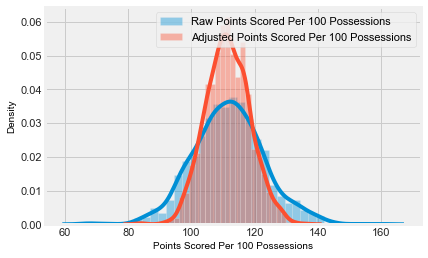

In [48]:
figsize(12, 8)
sns.distplot(lineup_df_100['off_Pts/Poss'], 
             label='Raw Points Scored Per 100 Possessions')
sns.distplot(lineup_df_100['adj_off_Pts/Poss'], 
             label='Adjusted Points Scored Per 100 Possessions')
plt.xlabel('Points Scored Per 100 Possessions')
plt.legend()

In [49]:
league_avg = season_off_ratings[['off_Pts/Poss']].reset_index()\
                                                 .rename(columns={'off_Pts/Poss': 
                                                                  'league_avg_off_Pts/Poss'})
lineup_df_100 = lineup_df_100.merge(league_avg, how='left')
lineup_df_100['diff_to_league_avg'] = lineup_df_100['off_Pts/Poss'] - \
                                      lineup_df_100['league_avg_off_Pts/Poss']
lineup_df_100['adj_diff_to_league_avg'] = lineup_df_100['adj_off_Pts/Poss'] - \
                                          lineup_df_100['league_avg_off_Pts/Poss']

## Exploratory Data Analysis

### Ticket 1: How many types of lineups?

In [50]:
lineup_df_100.groupby('lineup_embedding')[['lineup_clusters']].count().shape

(204, 1)

### Ticket 2: What are the top 10 most popular lineups?

In [51]:
cluster_dict_detail

{1: 'Ballhandler (Iso+PnR)',
 0: 'Ballhandler (PnR)',
 2: 'Big (Post Up+Roll)',
 7: 'Big (Roll+Cut)',
 3: 'Big (Roll+Spot Up)',
 6: 'Wing (Off Screen)',
 4: 'Wing (Hand Off)',
 5: 'Wing (Spot Up+Transition)'}

In [52]:
def lineup_embedding_to_detail(s, cluster_dict_detail=cluster_dict_detail):
    detail = []
    lineup = s.split('-')
    for i in range(n_clusters):
        n = int(lineup[i])
        if n != 0:
            detail.append(f'{n} {cluster_dict_detail[i]}')
    return ' | '.join(detail)

In [53]:
t_2 = lineup_df_100.groupby('lineup_embedding')[['lineup_clusters']]\
                   .count().reset_index()\
                   .rename(columns={'lineup_clusters': 'num_lineups'})
t_2['lineup_detail'] = t_2['lineup_embedding'].apply(lineup_embedding_to_detail)
t_2.sort_values('num_lineups', ascending=False).head(10)

,lineup_embedding,num_lineups,lineup_detail
109,1-1-0-1-0-2-0-0,68,1 Ballhandler (PnR) | 1 Ballhandler (Iso+PnR) | 1 Big (Roll+Spot Up) | 2 Wing (Spot Up+Transition)
163,2-0-1-0-0-2-0-0,60,2 Ballhandler (PnR) | 1 Big (Post Up+Roll) | 2 Wing (Spot Up+Transition)
120,1-1-1-0-0-2-0-0,59,1 Ballhandler (PnR) | 1 Ballhandler (Iso+PnR) | 1 Big (Post Up+Roll) | 2 Wing (Spot Up+Transition)
154,2-0-0-1-0-2-0-0,45,2 Ballhandler (PnR) | 1 Big (Roll+Spot Up) | 2 Wing (Spot Up+Transition)
82,1-0-1-0-0-3-0-0,41,1 Ballhandler (PnR) | 1 Big (Post Up+Roll) | 3 Wing (Spot Up+Transition)
179,2-1-0-1-0-1-0-0,39,2 Ballhandler (PnR) | 1 Ballhandler (Iso+PnR) | 1 Big (Roll+Spot Up) | 1 Wing (Spot Up+Transition)
72,1-0-0-1-0-3-0-0,38,1 Ballhandler (PnR) | 1 Big (Roll+Spot Up) | 3 Wing (Spot Up+Transition)
108,1-1-0-1-0-1-1-0,35,1 Ballhandler (PnR) | 1 Ballhandler (Iso+PnR) | 1 Big (Roll+Spot Up) | 1 Wing (Spot Up+Transition) | 1 Wing (Off Screen)
124,1-1-1-1-0-1-0-0,30,1 Ballhandler (PnR) | 1 Ballhandler (Iso+PnR) | 1 Big (Post Up+Roll) | 1 Big (Roll+Spot Up) | 1 Wing (Spot Up+Transition)
41,0-2-0-1-0-2-0-0,29,2 Ballhandler (Iso+PnR) | 1 Big (Roll+Spot Up) | 2 Wing (Spot Up+Transition)


In [54]:
t_2.shape, t_2[t_2['num_lineups'] >= 10].shape, t_2[t_2['num_lineups'] >= 30].shape

((204, 3), (47, 3), (9, 3))

Distributions of lineups with # >= 30

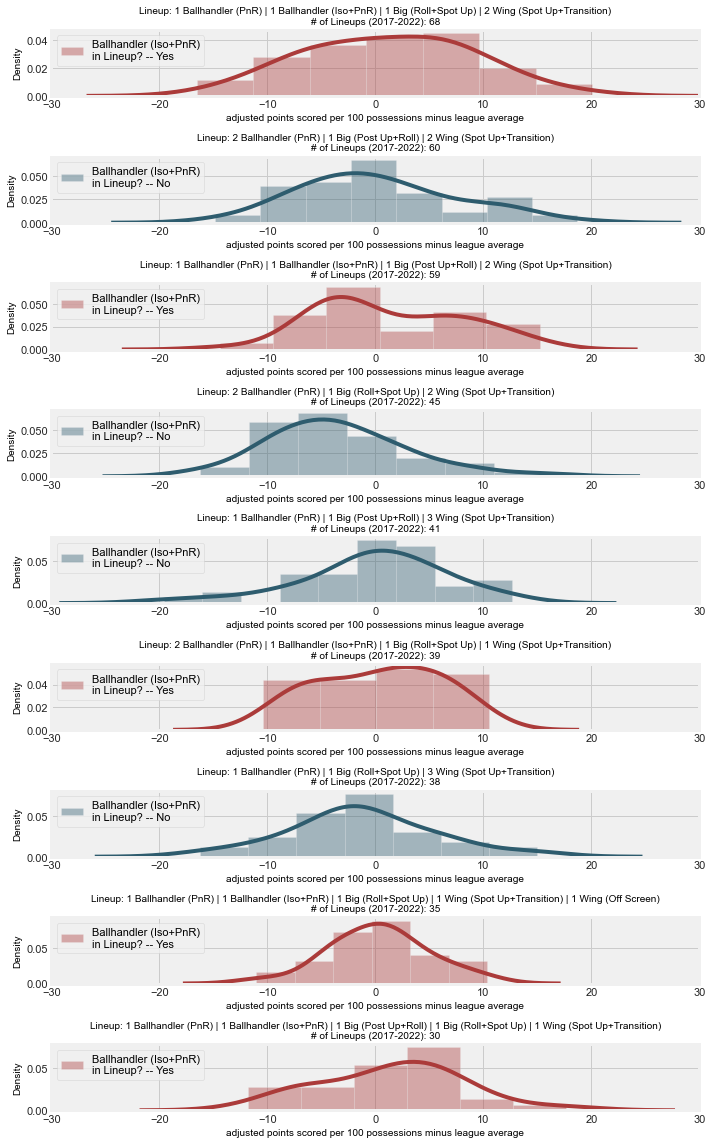

In [55]:
figsize(10, 16)

n = 9
temp = t_2.sort_values('num_lineups', ascending=False)\
          .head(n).values

for idx in range(n):
    le, num, ld = temp[idx]
    lineup_cond = lineup_df_100['lineup_embedding'] == le
    
    plt.subplot(n, 1, idx+1)
    title = f'Lineup: {ld}\n# of Lineups (2017-2022): {num}'
    plt.title(title)
    color = '#2E5C6E'
    label = 'Ballhandler (Iso+PnR)\nin Lineup? -- No'
    if 'Ballhandler (Iso+PnR)' in title:
        color = '#AB3B3A'
        label = label.replace('No', 'Yes')
    sns.distplot(lineup_df_100[lineup_cond]['adj_diff_to_league_avg'], 
                 color=color,
                 label=label)
    plt.xlabel('adjusted points scored per 100 possessions minus league average')
    plt.legend(loc='upper left')
    plt.xlim(-30, 30)
    
plt.tight_layout()

### Ticket 3: What are the most/least productive lineups?

Find 10 lineup types with the best offensive ratings

In [56]:
t_3 = lineup_df_100.groupby('lineup_embedding')[['adj_off_Pts/Poss',
                                                 'adj_diff_to_league_avg']]\
                   .mean().reset_index()
t_3['lineup_detail'] = t_3['lineup_embedding'].apply(lineup_embedding_to_detail)
t_3 = t_3.merge(t_2, how='left')
t_3.sort_values('adj_diff_to_league_avg', ascending=False).head(10)

,lineup_embedding,adj_off_Pts/Poss,adj_diff_to_league_avg,lineup_detail,num_lineups
185,2-1-2-0-0-0-0-0,136.400000,25.606102,2 Ballhandler (PnR) | 1 Ballhandler (Iso+PnR) | 2 Big (Post Up+Roll),1
14,0-1-0-0-0-2-2-0,125.423703,15.660237,1 Ballhandler (Iso+PnR) | 2 Wing (Spot Up+Transition) | 2 Wing (Off Screen),3
54,0-3-0-0-0-1-1-0,128.251674,15.456370,3 Ballhandler (Iso+PnR) | 1 Wing (Spot Up+Transition) | 1 Wing (Off Screen),1
24,0-1-0-2-0-2-0-0,124.830988,14.037090,1 Ballhandler (Iso+PnR) | 2 Big (Roll+Spot Up) | 2 Wing (Spot Up+Transition),1
142,1-2-2-0-0-0-0-0,121.500000,13.170012,1 Ballhandler (PnR) | 2 Ballhandler (Iso+PnR) | 2 Big (Post Up+Roll),1
159,2-0-1-0-0-0-1-1,124.095621,11.300317,2 Ballhandler (PnR) | 1 Big (Post Up+Roll) | 1 Wing (Off Screen) | 1 Big (Roll+Cut),1
30,0-1-2-0-0-1-1-0,119.200000,10.870012,1 Ballhandler (Iso+PnR) | 2 Big (Post Up+Roll) | 1 Wing (Spot Up+Transition) | 1 Wing (Off Screen),1
128,1-2-0-0-0-0-1-1,122.710627,10.455238,1 Ballhandler (PnR) | 2 Ballhandler (Iso+PnR) | 1 Wing (Off Screen) | 1 Big (Roll+Cut),2
36,0-2-0-0-1-1-0-1,121.540182,9.284793,2 Ballhandler (Iso+PnR) | 1 Wing (Hand Off) | 1 Wing (Spot Up+Transition) | 1 Big (Roll+Cut),1
65,1-0-0-0-1-3-0-0,119.555721,8.918670,1 Ballhandler (PnR) | 1 Wing (Hand Off) | 3 Wing (Spot Up+Transition),2


Find 10 common lineup types (at least 10 lineups) with the best offensive ratings

In [57]:
def color_cluster_1(l):
    if 'Ballhandler (Iso+PnR)' in l:
        return 'color: #AB3B3A' 
    else:
        return 'color: #2E5C6E' 

In [58]:
t_3[t_3['num_lineups'] >= 10].sort_values('adj_diff_to_league_avg', ascending=False)\
                             .head(10)[['lineup_detail', 
                                        'num_lineups',
                                        'adj_off_Pts/Poss',
                                        'adj_diff_to_league_avg']]\
                             .rename(columns={'lineup_detail': 'lineup combination',
                                              'num_lineups': '# of unique lineups',
                                              'adj_off_Pts/Poss': 'adj. points scored per 100 possessions',
                                              'adj_diff_to_league_avg': 'adj. difference to league average'})\
                             .style.format(precision=1).applymap(color_cluster_1, subset='lineup combination')

,lineup combination,# of unique lineups,adj. points scored per 100 possessions,adj. difference to league average
118,1 Ballhandler (PnR) | 1 Ballhandler (Iso+PnR) | 1 Big (Post Up+Roll) | 1 Wing (Spot Up+Transition) | 1 Big (Roll+Cut),16,116.4,5.2
145,2 Ballhandler (PnR) | 1 Wing (Spot Up+Transition) | 1 Wing (Off Screen) | 1 Big (Roll+Cut),13,115.0,4.9
131,1 Ballhandler (PnR) | 2 Ballhandler (Iso+PnR) | 2 Wing (Spot Up+Transition),13,115.3,3.7
101,1 Ballhandler (PnR) | 1 Ballhandler (Iso+PnR) | 3 Wing (Spot Up+Transition),14,115.2,3.5
21,1 Ballhandler (Iso+PnR) | 1 Big (Roll+Spot Up) | 3 Wing (Spot Up+Transition),25,113.6,3.4
35,2 Ballhandler (Iso+PnR) | 3 Wing (Spot Up+Transition),13,114.8,3.1
41,2 Ballhandler (Iso+PnR) | 1 Big (Roll+Spot Up) | 2 Wing (Spot Up+Transition),29,113.4,2.9
13,1 Ballhandler (Iso+PnR) | 2 Wing (Spot Up+Transition) | 1 Wing (Off Screen) | 1 Big (Roll+Cut),12,113.8,2.5
98,1 Ballhandler (PnR) | 1 Ballhandler (Iso+PnR) | 1 Wing (Spot Up+Transition) | 1 Wing (Off Screen) | 1 Big (Roll+Cut),18,111.3,2.0
129,1 Ballhandler (PnR) | 2 Ballhandler (Iso+PnR) | 1 Wing (Spot Up+Transition) | 1 Big (Roll+Cut),18,111.4,1.7


Find 10 common lineup types with worst offensive ratings

In [59]:
t_3[t_3['num_lineups'] >= 10].sort_values('adj_diff_to_league_avg')\
                             .head(10)[['lineup_detail', 
                                        'num_lineups',
                                        'adj_off_Pts/Poss',
                                        'adj_diff_to_league_avg']]\
                             .rename(columns={'lineup_detail': 'lineup combination',
                                              'num_lineups': '# of unique lineups',
                                              'adj_off_Pts/Poss': 'adj. points scored per 100 possessions',
                                              'adj_diff_to_league_avg': 'adj. difference to league average'})\
                             .style.format(precision=1).applymap(color_cluster_1, subset='lineup combination')

,lineup combination,# of unique lineups,adj. points scored per 100 possessions,adj. difference to league average
154,2 Ballhandler (PnR) | 1 Big (Roll+Spot Up) | 2 Wing (Spot Up+Transition),45,108.2,-3.5
153,2 Ballhandler (PnR) | 1 Big (Roll+Spot Up) | 1 Wing (Spot Up+Transition) | 1 Wing (Off Screen),23,107.2,-3.0
73,1 Ballhandler (PnR) | 1 Big (Roll+Spot Up) | 1 Wing (Hand Off) | 2 Wing (Spot Up+Transition),11,107.9,-2.7
77,1 Ballhandler (PnR) | 2 Big (Roll+Spot Up) | 2 Wing (Spot Up+Transition),13,108.5,-2.6
202,3 Ballhandler (PnR) | 1 Ballhandler (Iso+PnR) | 1 Big (Roll+Spot Up),10,110.1,-1.5
72,1 Ballhandler (PnR) | 1 Big (Roll+Spot Up) | 3 Wing (Spot Up+Transition),38,110.5,-1.2
90,1 Ballhandler (PnR) | 1 Big (Post Up+Roll) | 1 Big (Roll+Spot Up) | 2 Wing (Spot Up+Transition),17,110.1,-1.2
94,1 Ballhandler (PnR) | 2 Big (Post Up+Roll) | 2 Wing (Spot Up+Transition),19,109.1,-0.8
170,2 Ballhandler (PnR) | 2 Big (Post Up+Roll) | 1 Wing (Spot Up+Transition),28,109.5,-0.7
85,1 Ballhandler (PnR) | 1 Big (Post Up+Roll) | 1 Wing (Hand Off) | 2 Wing (Spot Up+Transition),20,110.9,-0.4


### Ticket 4: How good are the 'Death Lineups' of the Warriors?

In [60]:
lineup_df_100[(lineup_df_100['lineup_embedding'] == '0-1-0-0-0-2-2-0') &
              (lineup_df_100['team'] == 'Golden State Warriors')]\
.sort_values('adj_off_Pts/Poss', ascending=False).head(2)

,PG,SG,SF,PF,C,season,team,Poss,off_Pts/Poss_rank,off_Pts/Poss,off_eFG%_rank,off_eFG%,off_TOV%_rank,off_TOV%,off_OREB%_rank,off_OREB%,off_FTr_rank,off_FTr,PG_alt,SG_alt,SF_alt,PF_alt,C_alt,PG_cluster,SG_cluster,SF_cluster,PF_cluster,C_cluster,lineup_clusters,0,1,2,3,4,5,6,7,lineup_embedding,tm_off_Pts/Poss,adj_off_Pts/Poss,league_avg_off_Pts/Poss,diff_to_league_avg,adj_diff_to_league_avg
460,Stephen Curry,Klay Thompson,Andre Iguodala,Kevin Durant,Draymond Green,2018-2019,Golden State Warriors,388,96.0,132.5,98.0,65.9%,55.0,13.4%,4.0,15.6%,93.0,29.6,stephencurry,klaythompson,andreiguodala,kevindurant,draymondgreen,6.0,6.0,5.0,1.0,5.0,"[6.0, 6.0, 5.0, 1.0, 5.0]",0,1,0,0,0,2,2,0,0-1-0-0-0-2-2-0,116.488638,132.500000,110.480204,22.019796,22.019796
449,Stephen Curry,Klay Thompson,Andre Iguodala,Kevin Durant,Draymond Green,2017-2018,Golden State Warriors,275,97.0,127.6,92.0,59.9%,87.0,11.3%,18.0,19.7%,94.0,30.9,stephencurry,klaythompson,andreiguodala,kevindurant,draymondgreen,6.0,6.0,5.0,1.0,5.0,"[6.0, 6.0, 5.0, 1.0, 5.0]",0,1,0,0,0,2,2,0,0-1-0-0-0-2-2-0,113.744191,126.445349,108.329988,19.270012,18.115361


### Ticket 5: What are the differences that 'alpha/iso-heavy ballhandlers' can provide?

In [61]:
cluster_dict_detail

{1: 'Ballhandler (Iso+PnR)',
 0: 'Ballhandler (PnR)',
 2: 'Big (Post Up+Roll)',
 7: 'Big (Roll+Cut)',
 3: 'Big (Roll+Spot Up)',
 6: 'Wing (Off Screen)',
 4: 'Wing (Hand Off)',
 5: 'Wing (Spot Up+Transition)'}

In [62]:
lineup_df_100.groupby(1)['adj_diff_to_league_avg']\
             .agg(['count', 'mean'])\
             .reset_index()\
             .rename(columns={1: '# of Ballhandler (Iso+PnR) in the lineup',
                              'count': '# of unique lineups (100+ possessions)',
                              'mean': 'avg. adj. difference to league average'})\
             .style.format(precision=1)\
             .applymap(lambda x: 'color: #AB3B3A; font-weight: bold' if x > 0 
                       else 'color: #2E5C6E' , 
                       subset='# of Ballhandler (Iso+PnR) in the lineup')

,# of Ballhandler (Iso+PnR) in the lineup,# of unique lineups (100+ possessions),avg. adj. difference to league average
0,0,682,-0.6
1,1,606,1.5
2,2,242,2.3
3,3,20,4.0


In [63]:
lineup_df_100[lineup_df_100[1] == 3]\
.sort_values('adj_off_Pts/Poss', ascending=False).head(5)

,PG,SG,SF,PF,C,season,team,Poss,off_Pts/Poss_rank,off_Pts/Poss,off_eFG%_rank,off_eFG%,off_TOV%_rank,off_TOV%,off_OREB%_rank,off_OREB%,off_FTr_rank,off_FTr,PG_alt,SG_alt,SF_alt,PF_alt,C_alt,PG_cluster,SG_cluster,SF_cluster,PF_cluster,C_cluster,lineup_clusters,0,1,2,3,4,5,6,7,lineup_embedding,tm_off_Pts/Poss,adj_off_Pts/Poss,league_avg_off_Pts/Poss,diff_to_league_avg,adj_diff_to_league_avg
129,James Harden,Kyrie Irving,Joe Harris,Kevin Durant,Jeff Green,2020-2021,Brooklyn Nets,150,97.0,137.3,97.0,64.9%,45.0,14.0%,24.0,20.6%,64.0,19.6,jamesharden,kyrieirving,joeharris,kevindurant,jeffgreen,1.0,1.0,6.0,1.0,5.0,"[1.0, 1.0, 6.0, 1.0, 5.0]",0,3,0,0,0,1,1,0,0-3-0-0-0-1-1-0,119.203348,128.251674,112.795304,24.504696,15.456370
849,Jrue Holiday,Grayson Allen,Pat Connaughton,Khris Middleton,Giannis Antetokounmpo,2021-2022,Milwaukee Bucks,111,95.0,132.4,86.0,60.3%,33.0,14.4%,53.0,26.0%,97.0,32.0,jrueholiday,graysonallen,patconnaughton,khrismiddleton,giannisantetokounmpo,1.0,5.0,5.0,1.0,1.0,"[1.0, 5.0, 5.0, 1.0, 1.0]",0,3,0,0,0,2,0,0,0-3-0-0-0-2-0-0,115.508863,121.758584,112.255389,20.144611,9.503195
1028,Russell Westbrook,Paul George,Josh Huestis,Carmelo Anthony,Steven Adams,2017-2018,Oklahoma City Thunder,349,91.0,121.5,68.0,55.3%,44.0,14.6%,99.0,39.4%,54.0,18.2,russellwestbrook,paulgeorge,joshhuestis,carmeloanthony,stevenadams,1.0,1.0,5.0,1.0,7.0,"[1.0, 1.0, 5.0, 1.0, 7.0]",0,3,0,0,0,1,0,1,0-3-0-0-0-1-0-1,110.134239,121.500000,108.329988,13.170012,13.170012
847,Jrue Holiday,Pat Connaughton,Khris Middleton,Giannis Antetokounmpo,Bobby Portis,2021-2022,Milwaukee Bucks,117,92.0,129.9,94.0,62.9%,4.0,18.8%,78.0,30.0%,96.0,30.9,jrueholiday,patconnaughton,khrismiddleton,giannisantetokounmpo,bobbyportis,1.0,5.0,1.0,1.0,5.0,"[1.0, 5.0, 1.0, 1.0, 5.0]",0,3,0,0,0,2,0,0,0-3-0-0-0-2-0-0,115.508863,121.121406,112.255389,17.644611,8.866018
133,James Harden,Kyrie Irving,Joe Harris,Kevin Durant,DeAndre Jordan,2020-2021,Brooklyn Nets,107,73.0,120.6,84.0,60.9%,23.0,15.9%,44.0,23.8%,95.0,28.7,jamesharden,kyrieirving,joeharris,kevindurant,deandrejordan,1.0,1.0,6.0,1.0,7.0,"[1.0, 1.0, 6.0, 1.0, 7.0]",0,3,0,0,0,0,1,1,0-3-0-0-0-0-1-1,119.203348,119.701487,112.795304,7.804696,6.906183


## Modeling

### Linear Regression

In [64]:
data = lineup_df_100[list(range(n_clusters))]
y = lineup_df_100['adj_diff_to_league_avg'].values

In [65]:
categorical_cols = [[f'{cluster_dict_detail[i]} - {n}' 
                     for n in sorted(data[i].unique()) if n != 0]
                     for i in range(n_clusters)]
categorical_cols

[['Ballhandler (PnR) - 1', 'Ballhandler (PnR) - 2', 'Ballhandler (PnR) - 3'],
 ['Ballhandler (Iso+PnR) - 1',
  'Ballhandler (Iso+PnR) - 2',
  'Ballhandler (Iso+PnR) - 3'],
 ['Big (Post Up+Roll) - 1', 'Big (Post Up+Roll) - 2'],
 ['Big (Roll+Spot Up) - 1',
  'Big (Roll+Spot Up) - 2',
  'Big (Roll+Spot Up) - 3'],
 ['Wing (Hand Off) - 1', 'Wing (Hand Off) - 2', 'Wing (Hand Off) - 3'],
 ['Wing (Spot Up+Transition) - 1',
  'Wing (Spot Up+Transition) - 2',
  'Wing (Spot Up+Transition) - 3',
  'Wing (Spot Up+Transition) - 4'],
 ['Wing (Off Screen) - 1', 'Wing (Off Screen) - 2'],
 ['Big (Roll+Cut) - 1']]

In [66]:
data_encoded = pd.DataFrame(OneHotEncoder(drop='first').fit_transform(data).toarray(),
                            columns=list(itertools.chain(*categorical_cols)))
data_encoded.head(1)

,Ballhandler (PnR) - 1,Ballhandler (PnR) - 2,Ballhandler (PnR) - 3,Ballhandler (Iso+PnR) - 1,Ballhandler (Iso+PnR) - 2,Ballhandler (Iso+PnR) - 3,Big (Post Up+Roll) - 1,Big (Post Up+Roll) - 2,Big (Roll+Spot Up) - 1,Big (Roll+Spot Up) - 2,Big (Roll+Spot Up) - 3,Wing (Hand Off) - 1,Wing (Hand Off) - 2,Wing (Hand Off) - 3,Wing (Spot Up+Transition) - 1,Wing (Spot Up+Transition) - 2,Wing (Spot Up+Transition) - 3,Wing (Spot Up+Transition) - 4,Wing (Off Screen) - 1,Wing (Off Screen) - 2,Big (Roll+Cut) - 1
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [67]:
X = sm.add_constant(data_encoded)
model = sm.OLS(y, X)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     4.832
Date:                Wed, 01 Mar 2023   Prob (F-statistic):           1.33e-11
Time:                        16:53:41   Log-Likelihood:                -5116.3
No. Observations:                1550   AIC:                         1.027e+04
Df Residuals:                    1529   BIC:                         1.039e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.5218      1.079      0.484      0.629      -1.594       2.637
Ballhandler (PnR) - 1            -0.7693      0.520     -1.480      0.139      -1.789       0.250
Ballhandler (PnR) - 2            -0.2042      0.651     -0.313      0.754      -1.482       1.074
Ballhandler (PnR) - 3             0.2601      1.071      0.243      0.808      -1.840       2.360
Ballhandler (Iso+PnR) - 1         2.3236      0.433      5.367      0.000       1.474       3.173
Ballhandler (Iso+PnR) - 2         2.8508      0.639      4.462      0.000       1.597       4.104
Ballhandler (Iso+PnR) - 3         3.9754      1.539      2.583      0.010       0.956       6.995
Big (Post Up+Roll) - 1            0.1314      0.449      0.293      0.770      -0.749       1.012
Big (Post Up+Roll) - 2            0.8864      0.821      1.079      0.281      -0.724       2.497
Big (Roll+Spot Up) - 1           -1.1871      0.463     -2.566      0.010      -2.095      -0.280
Big (Roll+Spot Up) - 2           -3.0929      1.091     -2.836      0.005      -5.232      -0.954
Big (Roll+Spot Up) - 3            1.1480      6.158      0.186      0.852     -10.931      13.227
Wing (Hand Off) - 1               0.9481      0.613      1.547      0.122      -0.254       2.151
Wing (Hand Off) - 2              -3.0616      1.477     -2.073      0.038      -5.959      -0.165
Wing (Hand Off) - 3              -3.1912      4.383     -0.728      0.467     -11.788       5.406
Wing (Spot Up+Transition) - 1    -0.4603      0.553     -0.833      0.405      -1.544       0.624
Wing (Spot Up+Transition) - 2    -0.7280      0.626     -1.162      0.245      -1.957       0.501
Wing (Spot Up+Transition) - 3     0.3280      0.840      0.391      0.696      -1.319       1.975
Wing (Spot Up+Transition) - 4    -0.8567      1.632     -0.525      0.600      -4.057       2.344
Wing (Off Screen) - 1             0.1178      0.467      0.252      0.801      -0.798       1.033
Wing (Off Screen) - 2             2.0432      1.183      1.727      0.084      -0.277       4.364
Big (Roll+Cut) - 1               -0.0166      0.518     -0.032      0.975      -1.034       1.000
==============================================================================
Omnibus:                        4.057   Durbin-Watson:                   1.570
Prob(Omnibus):                  0.132   Jarque-Bera (JB):                4.646
Skew:                          -0.007   Prob(JB):                       0.0980
Kurtosis:                       3.268   Cond. No.                     2.81e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.46e-28. This might indicat

In [68]:
coef_df = pd.DataFrame(res.params, 
                       columns=['coef']).reset_index()\
                                        .rename(columns={'index': 'feature'})
coef_df['p_value'] = coef_df['feature'].map(res.pvalues)
coef_df[coef_df['p_value'] < 0.05].sort_values('coef', ascending=False)\
                                  .style.format(precision=3)\
                                  .applymap(color_cluster_1, subset='feature')

,feature,coef,p_value
6,Ballhandler (Iso+PnR) - 3,3.975,0.010
5,Ballhandler (Iso+PnR) - 2,2.851,0.000
4,Ballhandler (Iso+PnR) - 1,2.324,0.000
9,Big (Roll+Spot Up) - 1,-1.187,0.010
13,Wing (Hand Off) - 2,-3.062,0.038
10,Big (Roll+Spot Up) - 2,-3.093,0.005


### Bayesian Modeling

#### Functions

In [69]:
def team_cluster_lookup(season, team, label_df=label_df):
    return label_df[(label_df['season'] == season) &
                    (label_df['team'] == team)]

In [70]:
def generate_player_queries(player, season, cluster):
    A_query = ' | '.join([f'{pos} == "{player}"' for pos in positions])
    B_query = ' & '.join([f'{pos} != "{player}"' for pos in positions])
    return A_query, B_query

### Ticket 1: 
#### Get Expectation of Steph Curry/Klay Thompson/Draymond Green

In [73]:
# team_cluster_lookup('2021-2022', 'Golden State Warriors')

In [74]:
# L_cond = (lineup_df_100[6] > 1) & (lineup_df_100[5] > 0)
# lineups_L = lineup_df_100[L_cond]['adj_diff_to_league_avg'].values
# len(lineups_L)

In [75]:
# avg_diff_L = np.mean(lineups_L)
# var_diff_L = np.var(lineups_L)
# alpha_L = 1 / var_diff_L
# observations_L = list(lineups_L)

In [76]:
# with pm.Model() as model:
#     mu_L = pm.Uniform('mu_L', -20, 20)
#     var_L = pm.Exponential('var_L', alpha_L)
#     obs_L = pm.Normal('obs_L', mu_L, var_L, observed=observations_L)
    
#     step = pm.Metropolis()
#     trace = pm.sample(20000, step=step)

In [77]:
# burned_trace = trace[2000:]
# mu_L_samples = burned_trace['mu_L']

In [78]:
# figsize(13, 4)

# #histogram of posteriors
# plt.hist(mu_L_samples, histtype='stepfilled', bins=25, alpha=0.85,
#          label=r'posterior of $\mu L$', color='#A60628')
# plt.vlines(avg_diff_L, 0, 10000, linestyle='--', 
#            label=r'observed $\mu L$')
# plt.legend(loc='upper right')
# plt.xlim(-10, 10)
# plt.xlabel('adjusted points scored per 100 possessions minus league average')
# plt.title(r'Posterior distributions of $\mu L$')

### Two-Lineup-Configuration Comparison

A Bayesisan model that we can use is as follows:  
$x_A$ ~ $\mathcal{N}(\mu_A, \sigma_A)$  
$x_A$ ~ $\mathcal{N}(\mu_B, \sigma_B)$  
$\mu_A$ ~ $\mathcal{Uniform}(-20, 20)$  
$\mu_B$ ~ $\mathcal{Uniform}(-20, 20)$  
$\sigma_A$ ~ $\mathcal{Exp}(\alpha_A)$  
$\sigma_B$ ~ $\mathcal{Exp}(\alpha_B)$  
$\Delta$ = $\mu_A-\mu_B$

In [79]:
def compare_lineup_efficiency(lineups_A, lineups_B):
    avg_diff_A = np.mean(lineups_A)
    avg_diff_B = np.mean(lineups_B)
    print(f'Mean | A: {avg_diff_A:.2f}; B: {avg_diff_B:.2f}')
    
    var_diff_A = np.var(lineups_A)
    var_diff_B = np.var(lineups_B)
    print(f'Variance | A: {var_diff_A:.2f}; B: {var_diff_B:.2f}')
    
    alpha_A = 1 / var_diff_A
    alpha_B = 1 / var_diff_B
    
    observations_A = list(lineups_A)
    observations_B = list(lineups_B)
    
    with pm.Model() as model:
        mu_A = pm.Uniform('mu_A', -20, 20)
        mu_B = pm.Uniform('mu_B', -20, 20)

        delta = pm.Deterministic('delta', mu_A - mu_B)

        var_A = pm.Exponential('var_A', alpha_A)
        var_B = pm.Exponential('var_B', alpha_B)

        obs_A = pm.Normal('obs_A', mu_A, var_A, observed=observations_A)
        obs_B = pm.Normal('obs_B', mu_B, var_B, observed=observations_B)

        step = pm.Metropolis()
        trace = pm.sample(20000, step=step)
        
    return trace, avg_diff_A, avg_diff_B

In [81]:
cluster_dict_detail

{1: 'Ballhandler (Iso+PnR)',
 0: 'Ballhandler (PnR)',
 2: 'Big (Post Up+Roll)',
 7: 'Big (Roll+Cut)',
 3: 'Big (Roll+Spot Up)',
 6: 'Wing (Off Screen)',
 4: 'Wing (Hand Off)',
 5: 'Wing (Spot Up+Transition)'}

### Ticket 2: 
#### Lineups w/ 1 Wing (Off Screen)
#### vs. 
#### Lineups w/ 0 Wing (Off Screen)

In [108]:
cluster_dict_detail

{1: 'Ballhandler (Iso+PnR)',
 0: 'Ballhandler (PnR)',
 2: 'Big (Post Up+Roll)',
 7: 'Big (Roll+Cut)',
 3: 'Big (Roll+Spot Up)',
 6: 'Wing (Off Screen)',
 4: 'Wing (Hand Off)',
 5: 'Wing (Spot Up+Transition)'}

In [109]:
no_curry_cond = lineup_df_100['PG'] != 'Stephen Curry'
A_cond = lineup_df_100[6] == 1
B_cond = (lineup_df_100[6] == 0) & (lineup_df_100[4] == 0) & (lineup_df_100[5] == 0)

In [110]:
lineups_A = lineup_df_100[no_curry_cond][A_cond]['adj_diff_to_league_avg'].values
lineups_B = lineup_df_100[no_curry_cond][B_cond]['adj_diff_to_league_avg'].values
len(lineups_A), len(lineups_B)

(316, 68)

In [111]:
trace, avg_diff_A, avg_diff_B = compare_lineup_efficiency(lineups_A, 
                                                          lineups_B)

Mean | A: 0.58; B: 2.24
Variance | A: 41.55; B: 47.94


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [var_B]
>Metropolis: [var_A]
>Metropolis: [mu_B]
>Metropolis: [mu_A]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 38 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [112]:
burned_trace = trace[2000:]
mu_A_samples = burned_trace['mu_A']
mu_B_samples = burned_trace['mu_B']
delta_samples = burned_trace['delta']

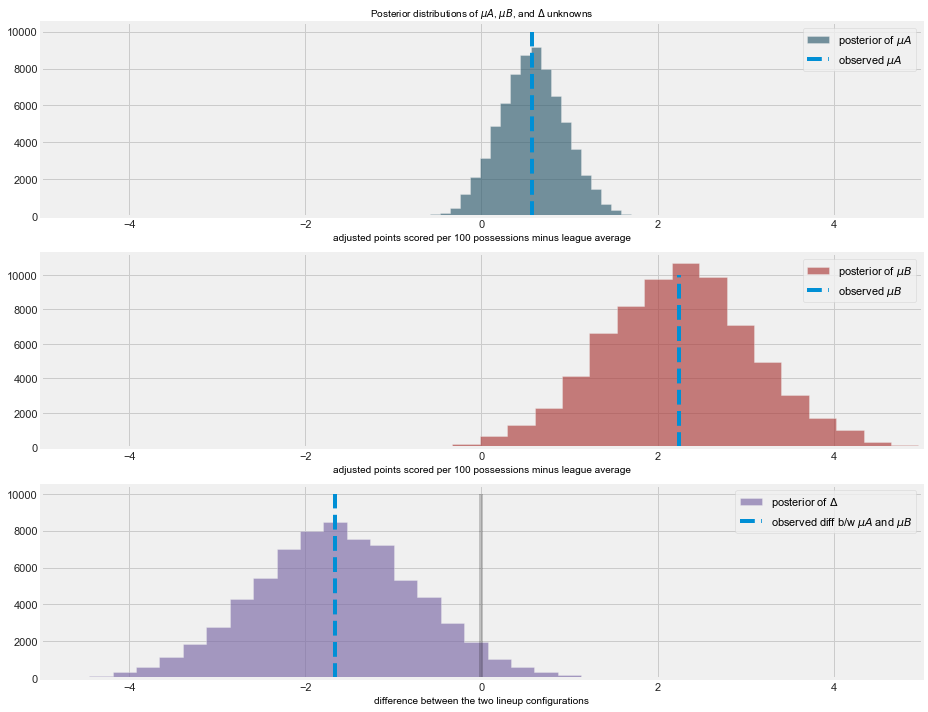

In [113]:
figsize(13, 10)

#histogram of posteriors

plt.subplot(3, 1, 1)
plt.hist(mu_A_samples, histtype='stepfilled', bins=25, alpha=0.65,
         label=r'posterior of $\mu A$', color='#2E5C6E')
plt.vlines(avg_diff_A, 0, 10000, linestyle='--', 
           label=r'observed $\mu A$')
plt.legend(loc='upper right')
plt.xlim(-5, 5)
plt.xlabel('adjusted points scored per 100 possessions minus league average')
plt.title(r'Posterior distributions of $\mu A$, $\mu B$, and $\Delta$ unknowns')

plt.subplot(3, 1, 2)
plt.hist(mu_B_samples, histtype='stepfilled', bins=25, alpha=0.65,
         label=r'posterior of $\mu B$', color='#AB3B3A')
plt.vlines(avg_diff_B, 0, 10000, linestyle='--', 
           label=r'observed $\mu B$')
plt.legend(loc='upper right')
plt.xlim(-5, 5)
plt.xlabel('adjusted points scored per 100 possessions minus league average')

plt.subplot(3, 1, 3)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.65,
         label=r'posterior of $\Delta$', color='#7A68A6')
plt.vlines(avg_diff_A - avg_diff_B, 0, 10000, linestyle='--',
           label=r'observed diff b/w $\mu A$ and $\mu B$')
plt.vlines(0, 0, 10000, color='black', alpha=0.2)
plt.legend(loc='upper right');
plt.xlim(-5, 5)
plt.xlabel('difference between the two lineup configurations')

plt.tight_layout()

### Player Performance Comparison

A Bayesisan model that we can use is as follows:  
$x_A$ ~ $\mathcal{N}(\mu_A, \sigma_A)$  
$x_A$ ~ $\mathcal{N}(\mu_B, \sigma_B)$  
$x_T$ ~ $\mathcal{N}(\mu_T, \sigma_T)$  
$\mu_A$ ~ $\mathcal{Uniform}(-20, 20)$  
$\mu_B$ ~ $\mathcal{Uniform}(-20, 20)$  
$\mu_T$ ~ $\mathcal{Uniform}(-20, 20)$  
$\sigma_A$ ~ $\mathcal{Exp}(\alpha_A)$  
$\sigma_B$ ~ $\mathcal{Exp}(\alpha_B)$  
$\sigma_T$ ~ $\mathcal{Exp}(\alpha_T)$  
$\Delta$ = $\mu_A-\mu_B$

In [ ]:
# def compare_player_efficiency(lineups_A, lineups_B, lineups_T):
#     avg_diff_A = np.mean(lineups_A)
#     avg_diff_B = np.mean(lineups_B)
#     avg_diff_T = np.mean(lineups_T)
    
#     var_diff_A = np.var(lineups_A)
#     var_diff_B = np.var(lineups_B)
#     var_diff_T = np.var(lineups_T)
    
#     alpha_A = 1 / var_diff_A
#     alpha_B = 1 / var_diff_B
#     alpha_T = 1 / var_diff_T
    
#     observations_A = list(lineups_A)
#     observations_B = list(lineups_B)
#     observations_T = list(lineups_T)
    
#     with pm.Model() as model:
#         mu_A = pm.Uniform('mu_A', -20, 20)
#         mu_B = pm.Uniform('mu_B', -20, 20)
#         mu_T  = pm.Uniform('mu_T', -20, 20)

#         delta = pm.Deterministic('delta', mu_A - mu_B)

#         var_A = pm.Exponential('var_A', alpha_A)
#         var_B = pm.Exponential('var_B', alpha_B)
#         var_T = pm.Exponential('var_T', alpha_T)

#         obs_A = pm.Normal('obs_A', mu_A, var_A, observed=observations_A)
#         obs_B = pm.Normal('obs_B', mu_B, var_B, observed=observations_B)
#         obs_T = pm.Normal('obs_T', mu_T, var_T, observed=observations_T)

#         step = pm.Metropolis()
#         trace = pm.sample(20000, step=step)
        
#     return trace, avg_diff_A, avg_diff_B, avg_diff_T

### Ticket 6: 
#### Lineups w/ Nikola Jokic
#### vs. 
#### Lineups w/ Similar Configurations

In [ ]:
# team_cluster_lookup(2021, 'Denver Nuggets')

In [ ]:
# player = 'Nikola Jokic'
# team = 'Denver Nuggets'
# season = 2021
# cluster = 6

In [ ]:
# A_query, B_query = generate_player_queries(player, season, cluster)
# season_cond = lineup_df_100['season'] == season
# cluster_cond = lineup_df_100[cluster] > 0
# team_cond = lineup_df_100['team'] == team

In [ ]:
# lineups_A = lineup_df_100[season_cond & cluster_cond].query(A_query)\
#             ['adj_diff_to_league_avg'].values
# lineups_B = lineup_df_100[season_cond & cluster_cond].query(B_query)\
#             ['adj_diff_to_league_avg'].values
# lineups_T = lineup_df_100[season_cond & team_cond]\
#             ['adj_diff_to_league_avg'].values
# len(lineups_A), len(lineups_B), len(lineups_T)

In [ ]:
# lineup_df_100[season_cond & cluster_cond].query(A_query)\
# [positions + ['Poss', 'adj_diff_to_league_avg']]

In [ ]:
# dump = compare_player_efficiency(lineups_A, lineups_B, lineups_T)
# trace, avg_diff_A, avg_diff_B, avg_diff_T = dump

In [ ]:
# burned_trace = trace[2000:]
# mu_A_samples = burned_trace['mu_A']
# mu_B_samples = burned_trace['mu_B']
# mu_T_samples = burned_trace['mu_T']
# delta_samples = burned_trace['delta']

In [ ]:
# figsize(13, 10)

# #histogram of posteriors

# plt.subplot(3, 1, 1)
# plt.hist(mu_A_samples, histtype='stepfilled', bins=25, alpha=0.65,
#          label=r'posterior of $\mu A$', color='#2E5C6E')
# plt.vlines(avg_diff_A, 0, 20000, linestyle='--', 
#            label=r'observed $\mu A$')
# plt.legend(loc='upper right')
# plt.xlim(-15, 15)
# plt.xlabel('adjusted points scored per 100 possessions minus league average')
# plt.title(r'Posterior distributions of $\mu A$, $\mu B$, and $\Delta$ unknowns')

# plt.subplot(3, 1, 2)
# plt.hist(mu_B_samples, histtype='stepfilled', bins=25, alpha=0.65,
#          label=r'posterior of $\mu B$', color='#AB3B3A')
# plt.vlines(avg_diff_B, 0, 20000, linestyle='--', 
#            label=r'observed $\mu B$')
# # plt.hist(mu_T_samples, histtype='stepfilled', bins=25, alpha=0.65,
# #          label=r'posterior of $\mu T$', color='yellow')
# # plt.vlines(avg_diff_T, 0, 20000, linestyle='-', 
# #            label=r'observed $\mu T$')
# plt.legend(loc='upper right')
# plt.xlim(-15, 15)
# plt.xlabel('adjusted points scored per 100 possessions minus league average')

# plt.subplot(3, 1, 3)
# plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.65,
#          label=r'posterior of $\Delta$', color='#7A68A6')
# plt.vlines(avg_diff_A - avg_diff_B, 0, 20000, linestyle='--',
#            label=r'observed diff b/w $\mu A$ and $\mu B$')
# plt.vlines(0, 0, 20000, color='black', alpha=0.2)
# plt.legend(loc='upper right');
# plt.xlim(-15, 15)
# plt.xlabel('difference between the two lineup configurations')

# plt.tight_layout()

In [ ]:
# np.mean(delta_samples > 0)

In [ ]:
# np.mean(delta_samples)